<a href="https://colab.research.google.com/github/jbq2/CS301-101-team7_SemanticSegmentation/blob/milestone-3/CS301_101_TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# required installation of all dependencies required
!pip install sklearn
!pip install numpy
!pip install matplotlib
!pip install patchify
!pip install Pillow
!pip install segmentation_models
!pip install keras
!pip install opencv-python
!pip install pyngrok
!pip install hpbandster
!pip install ConfigSpace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Installing NNI and loading interface with ngrok

!pip install nni
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip # download ngrok and unzip it
!unzip ngrok-stable-linux-amd64.zip
!pip install pyngrok
!mkdir -p nni_repo
!git clone https://github.com/microsoft/nni.git nni_repo/nni # clone NNI's offical repo to get examples
!ngrok authtoken 2GmpXSplbu5kON4LBKYMX4BLUrc_HRnx32rrQa8XnSaMQhHQ
!nnictl create --config nni_repo/nni/examples/trials/mnist-pytorch/config.yml --port 5001 &
get_ipython().system_raw('./ngrok http 5001 &')
!curl -s http://localhost:4040/api/tunnels # don't change the port number 4040
# Link to NNI Interface - link following "public_url" in last line of output (https://xxxx-xx-xx-xx-xxx.ngrok.io)

In [ ]:
!nnictl stop --all  # command to stop all experiments

In [ ]:
!mkdir ~/.kaggle

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/Fall\ 2022/CS301/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
! unzip semantic-segmentation-of-aerial-imagery.zip

In [ ]:
# Downloading dataset from kaggle (peter's code)
!mkdir ~/.kaggle
!mv ~/../content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
!unzip semantic-segmentation-of-aerial-imagery.zip

In [ ]:
"""
This block of code will be for HPO.
HPO using HpBandster BOHB. 
First, set up a worker; workers will evaluate a hyperparam setting
and return the associated minimized loss from that setting.
"""

import numpy as np
import time
import socket, os

import ConfigSpace as cs
from hpbandster.core.worker import Worker

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


class MyWorker(Worker):
    def __init__(self, *args, sleep_interval=0, **kwargs):
        """
        TODO:

        Load data here.
        Basically the part where we set up the images and 
        matrices to train the model with.

        Not exatly sure what parts will need to be copied and
        pasted though.
        
        Still gotta figure this out
        """

        super().__init__(**kwargs)

        # what i got from the example is that we can preprocess
        # data in another block and make the dataset variables global
        # in this function, and set them to the self.data variables:

        global X_train, X_test, y_train, y_test

        self.img_rows = self.img_cols = 256
        self.x_train, self.y_train = X_train, y_train
        self.x_test, self.y_test   = X_test, y_test

    def compute(self, config, budget, **kwargs):
        """
        TODO: 

        This compute function is required since MyWorker extends Worker.
        Compute will be called repeatedly during optimization.

        config: dictionary containing sampled hyperparam configs.
        budget: amount of epochs the model will use to train (not sure
        how this will go because one of our hyperparams is # of epochs).

        Basically will be a copy and paste the following parts
        of fitting the data to the model:
        - initalizing weights
        - total loss = dice loss + focal loss
        - getting image dimensions (requires __init__ to load data)
        - get the simple multi unet model
        - compile it using the config hyperparams
        - model.fit
        """
        def jacard_coef(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)
            return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


        def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
        #Build the model
            inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
            #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
            s = inputs

            #Contraction path
            c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
            c1 = Dropout(0.2)(c1)  # Original 0.1
            c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
            p1 = MaxPooling2D((2, 2))(c1)
            
            c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
            c2 = Dropout(0.2)(c2)  # Original 0.1
            c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
            p2 = MaxPooling2D((2, 2))(c2)
            
            c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
            c3 = Dropout(0.2)(c3)
            c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
            p3 = MaxPooling2D((2, 2))(c3)
            
            c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
            c4 = Dropout(0.2)(c4)
            c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
            p4 = MaxPooling2D(pool_size=(2, 2))(c4)
            
            c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
            c5 = Dropout(0.3)(c5)
            c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
            
            #Expansive path 
            u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
            u6 = concatenate([u6, c4])
            c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
            c6 = Dropout(0.2)(c6)
            c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
            
            u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
            u7 = concatenate([u7, c3])
            c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
            c7 = Dropout(0.2)(c7)
            c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
            
            u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
            u8 = concatenate([u8, c2])
            c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
            c8 = Dropout(0.2)(c8)  # Original 0.1
            c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
            
            u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
            u9 = concatenate([u9, c1], axis=3)
            c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
            c9 = Dropout(0.2)(c9)  # Original 0.1
            c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
            
            outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
            
            model = Model(inputs=[inputs], outputs=[outputs])
            
            #NOTE: Compile the model in the main program to make it easy to test with various loss functions
            #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
            #model.summary()
            
            return model

        
        def get_model():
            return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


        # defining weights and total_loss
        weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
        dice_loss = sm.losses.DiceLoss(class_weights=weights)  # loss function that is widely used in computer vision: calculates similarity between 2 images 
        focal_loss = sm.losses.CategoricalFocalLoss()  # improved cross entropy loss function: adds more weight to easily misclassified examples
        total_loss = dice_loss + (1 * focal_loss)  # overall loss function combines dice_loss and focal_loss

        IMG_HEIGHT = X_train.shape[1]
        IMG_WIDTH  = X_train.shape[2]
        IMG_CHANNELS = X_train.shape[3]

        # getting multi unet model
        model = get_model()

        # defining optimizer based on config
        if config['optimizer'] == 'adam':
            Optimizer = keras.optimizers.Adam(lr=config['learning_rate'])
        else:
            Optimizer = keras.optimizers.SGD(lr=config['learning_rate'], momentum=config['sgd_momentum'])

        # compiling with config hyperparams
        model.compile(loss=total_loss,
                      optimizer=Optimizer,
                      metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

        # fitting model with config
        history = model.fit(self.x_train, self.y_train,
                      batch_size=config['batch_size'],
                      epochs=int(budget),
                      # epochs=config['epochs'],
                      verbose=1,
                      validation_data=(self.x_test, self.y_test),
                      shuffle=False)

        # get train and test accuracy
        train_score = 1 - sum(history.history['loss']) / len(history.history['loss'])
        test_score = 1 - sum(history.history['val_loss']) / len(history.history['val_loss'])

        #import IPython; IPython.embed()
        return ({
                'loss': 1 - test_score, # remember: HpBandSter always minimizes!
                'info': {       
                    'test accuracy': test_score,
                    'train accuracy': train_score
                }
        })


    @staticmethod
    def get_configspace():
        """
        Hyperparameters of interest:
            - learning rate
            - optimizer (sgd or adam)
            - sgd_momentum
            - batch size
        """
        config_space = cs.ConfigurationSpace()
        learning_rate = cs.hyperparameters.UniformFloatHyperparameter('learning_rate', lower=0.0001, upper=0.1, default_value=0.001, log=True)
        optimizer = cs.hyperparameters.CategoricalHyperparameter('optimizer', ['adam', 'sgd'])
        sgd_momentum = cs.hyperparameters.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)
        batch_size = cs.hyperparameters.UniformIntegerHyperparameter('batch_size', lower=1, upper=32, default_value=16)
        # epochs = cs.hyperparameters.UniformIntegerHyperparameter('epochs', lower=30, upper=100, default_value=100)
        config_space.add_hyperparameters([learning_rate, optimizer, sgd_momentum, batch_size])
        return config_space

        

In [ ]:
from hpbandster.optimizers.bohb import BOHB
from hpbandster.core.nameserver import NameServer
import socket, os

NS = NameServer(run_id='example1', host='127.0.0.1', port=None)
NS.start()

worker = MyWorker(sleep_interval=0, nameserver='127.0.0.1', run_id='example1')
worker.run(background=True)
bohb = BOHB(configspace=worker.get_configspace(), run_id='example1', 
            nameserver='127.0.0.1', min_budget=30, max_budget=100)
result = bohb.run(n_iterations=5)

bohb.shutdown(shutdown_workers=True)
NS.shutdown()

print(result.get_all_runs())
print(result.get_pandas_dataframe())

## HPO Using BOHB (n = 5 iterations) Results:
![image](https://user-images.githubusercontent.com/98120760/202880199-55c25870-e8a9-4223-afec-aa84356bd939.png)

In [ ]:
# the last iteration of successive halving will be used
# assuming that after using BO-HB, the resulting config space is the most optimal

data_35_successive_halving_iterations=[
    {'batch_size': 25, 'learning_rate': 0.010423454645547298, 'optimizer': 'adam', 'sgd_momentum': 0.43521186058412903, 'budget': 25, 'loss': 1.2951, 'val_loss': 1.2842, 'precision': 0.54, 'recall': 0.54},
    {'batch_size': 26, 'learning_rate': 0.0006325494254217899, 'optimizer': 'sgd', 'sgd_momentum': 0.20260222918369616, 'budget': 25, 'loss': 1.0178, 'val_loss': 1.0177, 'precision': 0.9038, 'recall': 0.0000318},
    {'batch_size': 30, 'learning_rate': 0.006410637905687802, 'optimizer': 'sgd', 'sgd_momentum': 0.10204604192227403, 'budget': 25, 'loss': 1.0010, 'val_loss': 0.9982, 'precision': 0.8050, 'recall': 0.4666},
    {'batch_size': 30, 'learning_rate': 0.006410637905687802, 'optimizer': 'sgd', 'sgd_momentum': 0.10204604192227403, 'budget': 75, 'loss': 0.9958, 'val_loss': 0.9939, 'precision': 0.8305, 'recall': 0.4423},
    {'batch_size': 6, 'learning_rate': 0.00044712998042093497, 'optimizer': 'sgd', 'sgd_momentum': 0.6244634986402445, 'budget': 75, 'loss': 0.9970, 'val_loss': 0.9962, 'precision': 0.8313, 'recall': 0.4437},
    {'batch_size': 30, 'learning_rate': 0.0002555337726396552, 'optimizer': 'adam', 'sgd_momentum': 0.11425434943877688, 'budget': 75, 'loss': 0.8888, 'val_loss': 0.9412, 'precision': 0.8058, 'recall': 0.7889},
    {'batch_size': 24, 'learning_rate': 0.0012444573981454413, 'optimizer': 'adam', 'sgd_momentum': 0.22181057142726812, 'budget': 25, 'loss': 0.9066, 'val_loss': 0.9241, 'precision': 0.8336, 'recall': 0.8034},
    {'batch_size': 11, 'learning_rate': 0.000921560725725206, 'optimizer': 'sgd', 'sgd_momentum': 0.28005263182984264, 'budget': 25, 'loss': 1.0055, 'val_loss': 1.0026, 'precision': 0.8369, 'recall': 0.4438},
    {'batch_size': 26, 'learning_rate': 0.0008617202284439472, 'optimizer': 'sgd', 'sgd_momentum': 0.9596310724837166, 'budget': 25, 'loss': 0.9940, 'val_loss': 0.9922, 'precision': 0.8025, 'recall': 0.4704},
    {'batch_size': 24, 'learning_rate': 0.0012444573981454413, 'optimizer': 'adam', 'sgd_momentum': 0.22181057142726812, 'budget': 75, 'loss': 0.8981, 'val_loss': 0.9126, 'precision': 0.8549, 'recall': 0.8328},
    {'batch_size': 23, 'learning_rate': 0.012702172114669764, 'optimizer': 'adam', 'sgd_momentum': 0.5591241916566293, 'budget': 75, 'loss': 0.9411, 'val_loss': 0.9445, 'precision': 0.7746, 'recall': 0.7079},
    {'batch_size': 9, 'learning_rate': 0.05169249868326114, 'optimizer': 'sgd', 'sgd_momentum': 0.36091461749398956, 'budget': 75, 'loss': 0.9234, 'val_loss': 0.9470, 'precision': 0.7787, 'recall': 0.7364},
    {'batch_size': 11, 'learning_rate': 0.00393196591281057, 'optimizer': 'adam', 'sgd_momentum': 0.392466295122575, 'budget': 25, 'loss': 0.9144, 'val_loss': 0.9203, 'precision': 0.8297, 'recall': 0.7990},
    {'batch_size': 7, 'learning_rate': 0.005020592553323891, 'optimizer': 'adam', 'sgd_momentum': 0.4285698435087847, 'budget': 25, 'loss': 0.9395, 'val_loss': 0.9389, 'precision': 0.8032, 'recall': 0.7463},
    {'batch_size': 25, 'learning_rate': 0.033130188028715805, 'optimizer': 'sgd', 'sgd_momentum': 0.7767336836177672, 'budget': 25, 'loss': 0.9536, 'val_loss': 0.9662, 'precision': 0.7420, 'recall': 0.6090},
    {'batch_size': 11, 'learning_rate': 0.00393196591281057, 'optimizer': 'adam', 'sgd_momentum': 0.392466295122575, 'budget': 75, 'loss': 0.9130, 'val_loss': 0.9147, 'precision': 0.8437, 'recall': 0.8106},
    {'batch_size': 23, 'learning_rate': 0.0032847542515781567, 'optimizer': 'adam', 'sgd_momentum': 0.8016755715024376, 'budget': 75, 'loss': 0.9001, 'val_loss': 0.9171, 'precision': 0.8321, 'recall': 0.8160},
    {'batch_size': 26, 'learning_rate': 0.004794279849735609, 'optimizer': 'sgd', 'sgd_momentum': 0.12276821185304304, 'budget': 75, 'loss': 0.9952, 'val_loss': 0.9940, 'precision': 0.8080, 'recall': 0.4617},
    {'batch_size': 1, 'learning_rate': 0.035252990416093734, 'optimizer': 'adam', 'sgd_momentum': 0.9226147983361845, 'budget': 25, 'loss': 1.5115, 'val_loss': 1.5067, 'precision': 0.1425, 'recall': 0.1425},
    {'batch_size': 24, 'learning_rate': 0.000504924978646984, 'optimizer': 'sgd', 'sgd_momentum': 0.9886347100920375, 'budget': 25, 'loss': 0.9943, 'val_loss': 0.9932, 'precision': 0.8296, 'recall': 0.4517},
    {'batch_size': 28, 'learning_rate': 0.061566996059290544, 'optimizer': 'sgd', 'sgd_momentum': 0.9387601099445818, 'budget': 25, 'loss': 0.9362, 'val_loss': 0.9512, 'precision': 0.7744, 'recall': 0.6954},
    {'batch_size': 28, 'learning_rate': 0.061566996059290544, 'optimizer': 'sgd', 'sgd_momentum': 0.9387601099445818, 'budget': 75, 'loss': 0.9148, 'val_loss': 0.9287, 'precision': 0.8206, 'recall': 0.7839},
    {'batch_size': 24, 'learning_rate': 0.00012765657043279643, 'optimizer': 'adam', 'sgd_momentum': 0.06482325264227154, 'budget': 75, 'loss': 0.8963, 'val_loss': 0.9619, 'precision': 0.7486, 'recall': 0.7406},
    {'batch_size': 29, 'learning_rate': 0.000362997661710239, 'optimizer': 'adam', 'sgd_momentum': 0.980606513386686, 'budget': 75, 'loss': 0.8727, 'val_loss': 0.9247, 'precision': 0.8294, 'recall': 0.8178},
    {'batch_size': 27, 'learning_rate': 0.000559449566703158, 'optimizer': 'adam', 'sgd_momentum': 0.8351797515182519, 'budget': 25, 'loss': 0.9087, 'val_loss': 0.9307, 'precision': 0.8155, 'recall': 0.7799},
    {'batch_size': 30, 'learning_rate': 0.00020648284618882698, 'optimizer': 'sgd', 'sgd_momentum': 0.15901342208840763, 'budget': 25, 'loss': 1.0212, 'val_loss': 1.0226, 'precision': 0., 'recall': 0.},
    {'batch_size': 24, 'learning_rate': 0.02619168430040626, 'optimizer': 'sgd', 'sgd_momentum': 0.08896231525961767, 'budget': 25, 'loss': 0.9909, 'val_loss': 0.9900, 'precision': 0.8293, 'recall': 0.4482},
    {'batch_size': 27, 'learning_rate': 0.000559449566703158, 'optimizer': 'adam', 'sgd_momentum': 0.8351797515182519, 'budget': 75, 'loss': 0.8792, 'val_loss': 0.9177, 'precision': 0.8431, 'recall': 0.8303},
    {'batch_size': 30, 'learning_rate': 0.0003735348770269236, 'optimizer': 'adam', 'sgd_momentum': 0.8584977116587138, 'budget': 75, 'loss': 0.8828, 'val_loss': 0.9210, 'precision': 0.8303, 'recall': 0.8167},
    {'batch_size': 31, 'learning_rate': 0.0003401549016294108, 'optimizer': 'adam', 'sgd_momentum': 0.9254391870088128, 'budget': 75, 'loss': 0.8739, 'val_loss': 0.9247, 'precision': 0.8335, 'recall': 0.8183},
    {'batch_size': 11, 'learning_rate': 0.006379790977696792, 'optimizer': 'adam', 'sgd_momentum': 0.18897151412792534, 'budget': 25, 'loss': 0.9218, 'val_loss': 0.9277, 'precision': 0.8166, 'recall': 0.7696},
    {'batch_size': 23, 'learning_rate': 0.0029896701407367146, 'optimizer': 'sgd', 'sgd_momentum': 0.5460870135101618, 'budget': 25, 'loss': 1.0035, 'val_loss': 1.0015, 'precision': 0.8820, 'recall': 0.3698},
    {'batch_size': 6, 'learning_rate': 0.002547859030004373, 'optimizer': 'adam', 'sgd_momentum': 0.05517169349458934, 'budget': 25, 'loss': 0.9233, 'val_loss': 0.9271, 'precision': 0.8403, 'recall': 0.7984},
    {'batch_size': 11, 'learning_rate': 0.006379790977696792, 'optimizer': 'adam', 'sgd_momentum': 0.18897151412792534, 'budget': 75, 'loss': 0.9160, 'val_loss': 0.9216, 'precision': 0.8296, 'recall': 0.7942},
    {'batch_size': 9, 'learning_rate': 0.004740049723020277, 'optimizer': 'adam', 'sgd_momentum': 0.08967610463914634, 'budget': 75, 'loss': 0.9149, 'val_loss': 0.9198, 'precision': 0.8337, 'recall': 0.7966}
]

In [ ]:
# simple_multi_unet_model.py

# https://youtu.be/jvZm8REF2KY
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers. 
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

# 228_training_aerial_imagery.py

# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E

https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""

# import statements; had to change tensorflow keras metrics import
# proper path to keras metrics is tensorflow/python/keras/metrics
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.python.keras.metrics import MeanIoU
import keras

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()

root_directory = 'Semantic segmentation dataset/'  # idt this is the right root directory for us

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(files)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        images = sorted(images)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
                #print(image_name)
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(files)    
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        masks = sorted(masks)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
                #print(mask_name)
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages -- commented this out to reduce output size
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))  # throwing an out of bounds error
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
# print(a) # commented this out
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

# print("Unique labels in label dataset are: ", np.unique(labels)) # commented this out

#Another Sanity check, view few mages - commented this out to reduce the output size

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [ ]:
#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')), 
#                               np.ravel(labels,order='C'))
# print(weights)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)  # loss function that is widely used in computer vision: calculates similarity between 2 images 
focal_loss = sm.losses.CategoricalFocalLoss()  # improved cross entropy loss function: adds more weight to easily misclassified examples
total_loss = dice_loss + (1 * focal_loss)  # overall loss function combines dice_loss and focal_loss


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# from simple_multi_unet_model import multi_unet_model, jacard_coef  (not required because they are defined in a prev code block)

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

opt = keras.optimizers.Adam(lr=0.004740049723020277)
model = get_model()
model.compile(optimizer=opt, loss=total_loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 9, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

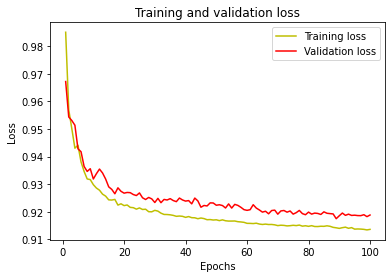

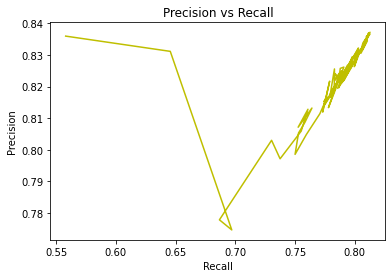

In [ ]:
###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

precision = history.history['val_precision_2']
recall = history.history['val_recall_2']

plt.plot(recall, precision, 'y', label='Precision vs Recall')
plt.title('Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
# this code block prints predictions on all images of X_test
# 10 of the best will be chosen
# only the 10 best will be shown for easier viewing

import random
for i in range(len(X_test)):
  print("Prediction", i+1)
  test_img = X_test[i]
  ground_truth=y_test[i]
  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  ground_truth=np.argmax(ground_truth, axis=2)[:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()

1/1 [==============================] - 0s 23ms/step


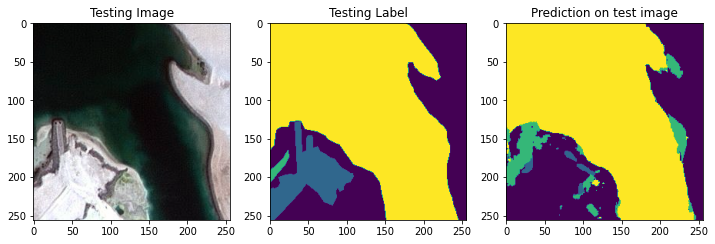

1/1 [==============================] - 0s 21ms/step


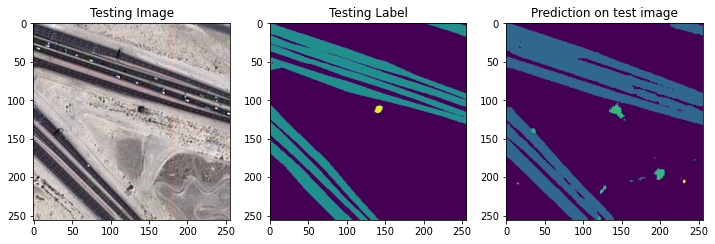

1/1 [==============================] - 0s 20ms/step


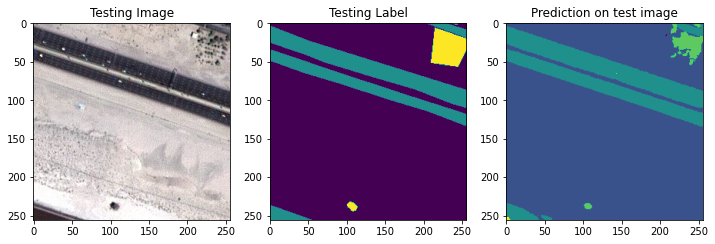

1/1 [==============================] - 0s 21ms/step


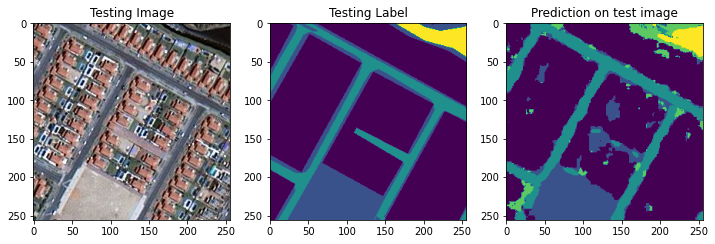

1/1 [==============================] - 0s 20ms/step


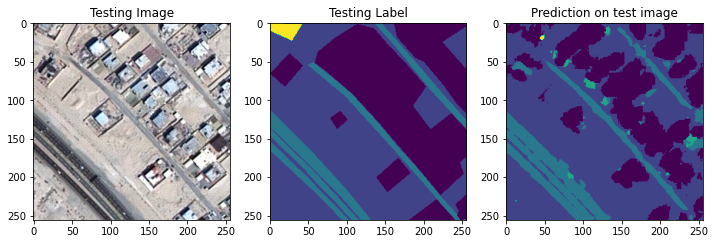

1/1 [==============================] - 0s 21ms/step


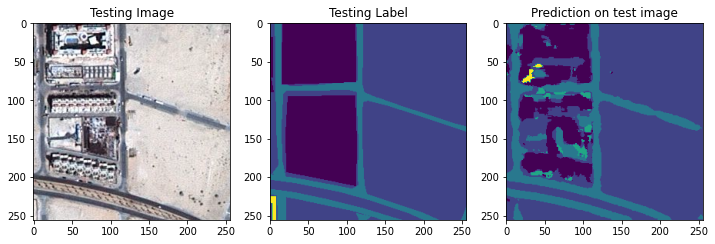

1/1 [==============================] - 0s 20ms/step


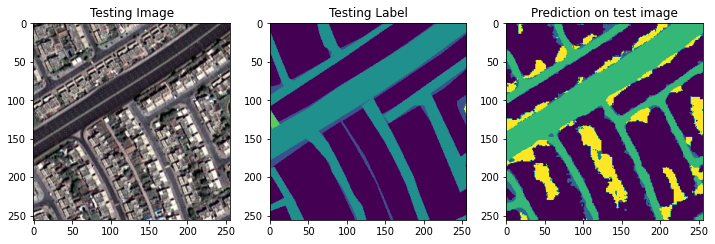

1/1 [==============================] - 0s 20ms/step


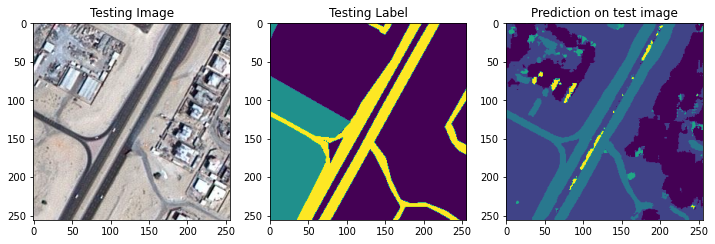

1/1 [==============================] - 0s 20ms/step


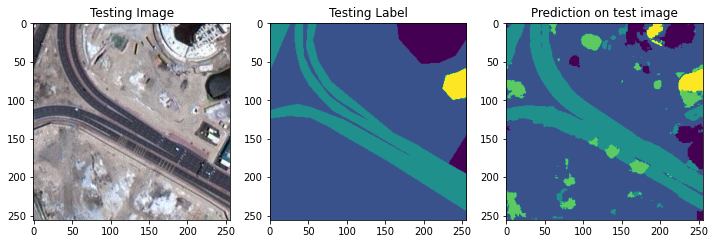

1/1 [==============================] - 0s 22ms/step


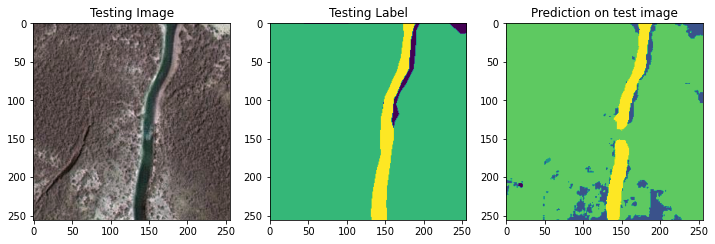

In [21]:
# 10 of the best predictions:

best = [0, 150, 142, 136, 129, 246, 235, 219, 211, 168]
for i in best:
  test_img = X_test[i]
  ground_truth=y_test[i]
  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  ground_truth=np.argmax(ground_truth, axis=2)[:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()